In [5]:
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import log_loss
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Question 1:
Dataset used: Taiwanese Bankruptcy Prediction

URL: https://archive.ics.uci.edu/dataset/572/taiwanese+bankruptcy+prediction

In [9]:
# Checking the number of columns and looking at the column headers.
with open('data.csv') as f:
    fields = f.readline().split(',')
print(len(fields),'\n', fields[:5])
# Reading in the data
data = np.loadtxt('data.csv',delimiter=',', skiprows=1)
print(data.shape)
x = data[:,1:] # First column contains the labels
y = data[:,0] # Labels of the data
print(x.shape, y.shape)

96 
 ['Bankrupt?', ' ROA(C) before interest and depreciation before interest', ' ROA(A) before interest and % after tax', ' ROA(B) before interest and depreciation after tax', ' Operating Gross Margin']
(6819, 96)
(6819, 95) (6819,)


In [22]:
def CrossFoldValidate(x, y, model, num_split):
    """
    Performs crossfold validation.
    Input:
    x (np.ndarray): feature data (num samples x num features)
    y (np.ndarray): lable data (num samples)
    model: The model used to perform the prediction
    num_split: the number of splits we want to use.
    """
    N, k = x.shape
    split_size = N//num_split
    # Create a list that contains the splits of the feature and labels
    list_x = []
    list_y = []
    for i in range(num_split):
        start = i*split_size
        if i == num_split - 1:
            end = N
        else:
            end = (i+1)*split_size
        list_x.append(x[start:end])
        list_y.append(y[start:end])

    # Perform the crossfold validation. 
    cumulative_loss = 0
    for i in range(num_split): 
        train_x = []
        train_y = []
        # Split the training and testing data for this iteration of cross-fold validation.
        for j in range(num_split-1):
            if j == 0:
                train_x = list_x[i]
                train_y = list_y[i]
            else:
                train_x = np.concatenate((train_x, list_x[(i+j)%num_split])) 
                train_y = np.concatenate((train_y, list_y[(i+j)%num_split])) 
        offline_model = model.fit(train_x,train_y)

        test_x = list_x[(i+num_split-1)%num_split]
        test_y = list_y[(i+num_split-1)%num_split]

        # Predict on the split that wasn't trained on.
        pred_y = offline_model.predict(test_x)

        # Add to the cumulative loss.
        cumulative_loss += log_loss(test_y, pred_y, normalize = False)
        
    # Normalize the cumulative loss before returning.
    return cumulative_loss/N



# Question 1
def Question1(x,y,seed=2024):
    N, k = x.shape

    gen = np.random.default_rng(seed)
    indexes = list(range(N))
    gen.shuffle(indexes)

    shuffled_x = x.copy()
    shuffled_y = y.copy()
    
    shuffled_x = shuffled_x[indexes]
    shuffled_y = shuffled_y[indexes]

    # Initialize SVC model pipeline. Standard scale first to make values between 0 and 1.
    model = make_pipeline(StandardScaler(), SVC())
    offline_cumulative_loss = CrossFoldValidate(shuffled_x, shuffled_y, model, 5)

    # Online Learning
    model = make_pipeline(StandardScaler(), SVC())
    online_cumulative_loss = 0

    for i in range(5):
        # Getting indicies for slicing the shuffled data.
        low = N//2+N//10*i
        if i < 4:
            high = N//2+N//10*(i+1)
        else:
            high = N

        online_model = model.fit(shuffled_x[:low], shuffled_y[:low])
        pred_y = online_model.predict(shuffled_x[low:high])
        online_cumulative_loss += log_loss(shuffled_y[low:high], pred_y, normalize=False)
    online_cumulative_loss /= N/2


    regret = online_cumulative_loss-offline_cumulative_loss
    print('Regret: ', regret)
    return regret

In [33]:
regrets = []
for i in range(5):
    regrets.append(Question1(x,y,i*5000))
regrets.append(np.mean(regrets))
err = [0]*5
err.append(np.std(regrets))

Regret:  -0.021143072819543862
Regret:  0.05814345025374523
Regret:  0.14271574153192002
Regret:  0.07400075486840274
Regret:  0.01585730461465773


Text(0.5, 1.0, 'Online vs Offline Regret')

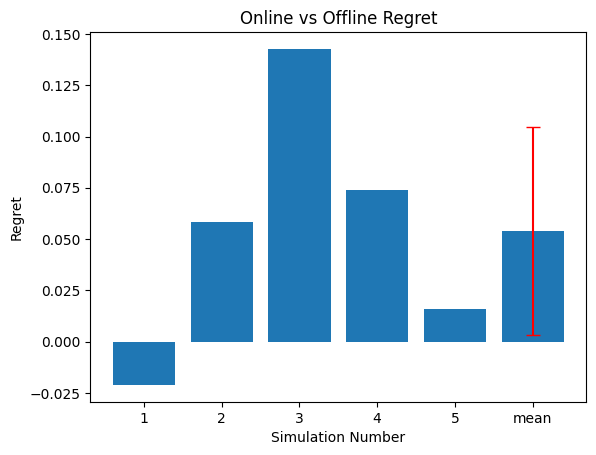

In [34]:
fig,ax = plt.subplots(1)
ax.bar(range(6), regrets)
ax.set_xticks(range(6), ['1', '2', '3', '4', '5', 'mean'])
ax.errorbar(5, regrets[-1], err[-1],color = 'r', capsize = 5)
ax.set_xlabel('Simulation Number')
ax.set_ylabel('Regret')
ax.set_title('Online vs Offline Regret')